# Importowanie bibliotek
- *subprocess* - uruchamianie programów zewnętrznych w skrypcie, uzyskiwanie z nich danych
- *numpy* - obliczenia macierzowe, działania na macierzach
- *matplotlib.pyplot* - biblioteka do rysowania wykresów w stylu MatLab'a
- *path* - do sprawdzenia, czy dane pliki istnieję
- *config* - plik konfiguracyjny do pomiarów
- *custom_statistics* - moduł zawierający funkcje służące do określania parametrów statystycznych (np. mediana, średnia, etc.)
- *custom_approx* - moduł zawierający funkcje służące do aproksymacji danych, oraz określania adekwatności modeli aproksymacyjnych

In [1]:
import subprocess
from os import path
import numpy as np
import config as cfg
import matplotlib.pyplot as plt
import custom_statistics as stat
import custom_approx as approx

# Uzyskiwanie wyników pomiarów
Wyniki uzyskiwane są jednorazowo (wtedy, kiedy pliki wyników nie istnieją).

In [2]:
if not path.isfile(cfg.preliminary['FILE_NAME']):
	prelim_U = np.zeros(cfg.preliminary['REPETITIONS'])

	for i in np.arange(cfg.preliminary['REPETITIONS']):
		program_output = subprocess.run(
			[cfg.executable['EXE_NAME'], str(cfg.preliminary['EXAMINED_POINT'])],
			capture_output=True, text=True
		)
		prelim_U[i] = program_output.stdout

	prelim_X = np.ones(cfg.preliminary['REPETITIONS'])*cfg.preliminary['EXAMINED_POINT']
	out = np.stack([prelim_X, prelim_U])
	np.savetxt(cfg.preliminary['FILE_NAME'], out, delimiter=",")

else:
	[prelim_X, prelim_U] = np.vsplit(
		np.genfromtxt(cfg.preliminary['FILE_NAME'], delimiter=','),
		2
	)

In [3]:
if not path.isfile(cfg.main['FILE_NAME']):
	main_X = np.linspace(
		cfg.main['START_POINT'],
		cfg.main['END_POINT'],
		cfg.main['NO_POINTS']
	)
	main_U = np.zeros(cfg.main['NO_POINTS'])

	for i, val in np.ndenumerate(main_X):
		program_output = subprocess.run(
			[cfg.executable['EXE_NAME'], str(val)],
			capture_output=True, text=True
		)
		main_U[i] = program_output.stdout

	out = np.stack([main_X, main_U])
	np.savetxt(cfg.main['FILE_NAME'], out, delimiter=",")

else:
	[main_X, main_U] = np.vsplit(
		np.genfromtxt(cfg.main['FILE_NAME'], delimiter=','),
		2
	)

In [4]:
prelim_U = np.transpose(prelim_U)
prelim_X = np.transpose(prelim_X)
main_U = np.transpose(main_U)
main_X = np.transpose(main_X)
prelim_U = prelim_U.reshape((-1,))
prelim_X = prelim_X.reshape((-1,))
main_U = main_U.reshape((-1,))
main_X = main_X.reshape((-1,))

# Wstępne zarysowanie wyników pomiarów

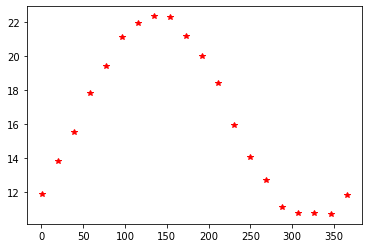

In [5]:
plt.plot(main_X, main_U, 'r*')
plt.show()

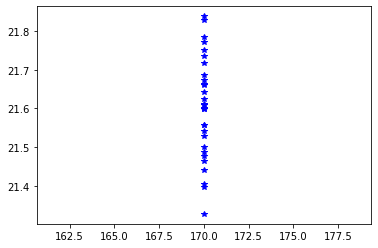

In [6]:
plt.plot(prelim_X, prelim_U, 'b*')
plt.show()

# Parametry statystyczne
Odpowiednio:
- wielkość próby
- średnia
- mediana
- wariancja
- odchylenie standardowe
- minimum
- maksimum

In [7]:
print(cfg.preliminary['REPETITIONS'])
print(
	stat.arr_average(prelim_U),
	stat.arr_median(prelim_U),
	stat.variance(prelim_U),
	stat.standard_deviation(prelim_U),
	stat.min_value(prelim_U),
	stat.max_value(prelim_U)
)

30
21.602826539000002 21.5015883 0.017134657374238905 0.13089941701260133 21.32782354 21.83798465


# Standaryzacja pomiarów do przedziału <-1; 1>
W kolejności obliczamy wartość średnią i jednostkę zmienności:
$$\bar{x}=\frac{x_{i,min} + x_{i,max}}{2}$$
$$\varDelta x=\frac{x_{i,max} + x_{i.min}}{2}$$
Następnie przeliczamy wartości $x_i$ do nowego ukladu współrzędnych:
$$t_i = \frac{x_i - \bar{x}}{\varDelta x}$$
gdzie $i = 1,2,...,N$

In [8]:
average_x = (main_X[0] + main_X[-1]) / (2)
delta_x   = (main_X[-1]+ main_X[0] ) / (2)
main_T = np.zeros(cfg.main['NO_POINTS'])

for i, val in np.ndenumerate(main_X):
	main_T[i] = (val - average_x)/delta_x

# main_T = [ (x - average_x)/delta_x for x in main_X ]
# main_T = np.ndarray(main_T)

In [9]:
print(stat.border_values(main_U))

(11.89026458, 11.85949719)


# Aproksymacja danych
Kolejno z użyciem:
- wielomianów wg. wzoru: $$y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + a_3 \cdot x^3 +...+ a_n \cdot x^n$$
- funkcji logarytmu naturalnego: $$y = a_0 + a_1 \cdot \ln(x) + a_2 \cdot \ln(x)^2 + ...$$
- z użyciem funkcji wymiernej wg. wzoru: $$y = a_0 + a_1 \cdot \left( \frac{1}{x} \right) + a_2 \cdot \left( \frac{1}{x} \right)^2 +...$$
- z użyciem funkcji trygonometrycznych: $$ a_0 + a_1 \cdot \cos(c \cdot x) + a_2 \cdot \sin(c \cdot x) + a_3 \cdot \cos(c\cdot 2x) + a_4 \cdot \sin(c \cdot 2x) + ...$$
gdzie c to stała, jaką dobieramy empirycznie tak aby uzyskać jak najbardziej dopasowany wykres.

Ważne aby zaznaczyć, że tak jak aproksymacje wielomianem i funkcjami trygonometrycznymi wykonujemy na danych standaryzowanych, tak dla aproksymacji logarytmem oraz funkcją wymierną jest to niemożliwe.


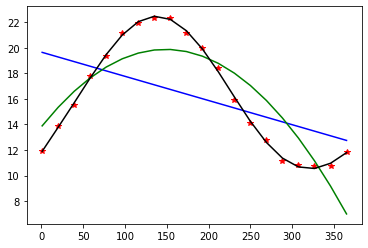

In [10]:
[first_deg_poly, fdpA] = approx.polynomial_approximation(main_X, main_U, 2)
[second_deg_poly, sdpA] = approx.polynomial_approximation(main_X, main_U, 3)
[seventh_deg_poly, adpA] = approx.polynomial_approximation(main_X, main_U, 8)
[first_deg_poly_s, fdpB] = approx.polynomial_approximation(main_T, main_U, 2)
[second_deg_poly_s, sdpB] = approx.polynomial_approximation(main_T, main_U, 3)
[seventh_deg_poly_s, adpB] = approx.polynomial_approximation(main_T, main_U, 8)
plt.plot(main_X, main_U, 'r*', main_X, first_deg_poly, 'b-', main_X, second_deg_poly, 'g-', main_X, seventh_deg_poly, 'k-')
plt.show()

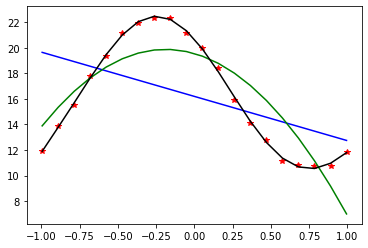

In [11]:
plt.plot(main_T, main_U, 'r*', main_T, first_deg_poly, 'b-', main_T, second_deg_poly, 'g-', main_T, seventh_deg_poly, 'k-')
plt.show()

[]

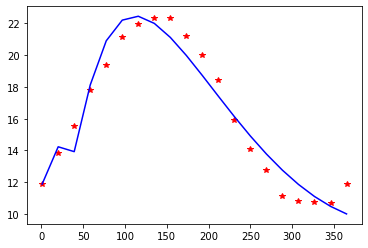

In [12]:
[nat_approx, naA] = approx.natlog_approximation(main_X, main_U, 6)
plt.plot(main_X, main_U, 'r*', main_X, nat_approx, 'b-')
plt.plot()

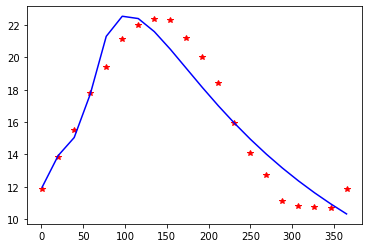

In [13]:
[rat_approx, raA] = approx.rational_approximation(main_X, main_U, 6)
[rat_approx_s, raB] = approx.rational_approximation(main_T, main_U, 6)
plt.plot(main_X, main_U, 'r*', main_X, rat_approx, 'b-')
plt.show()

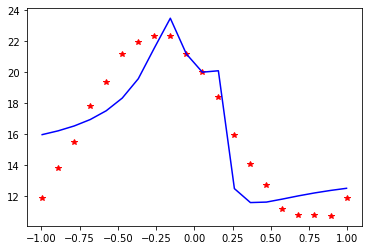

In [14]:
plt.plot(main_T, main_U, 'r*', main_T, rat_approx_s, 'b-')
plt.show()

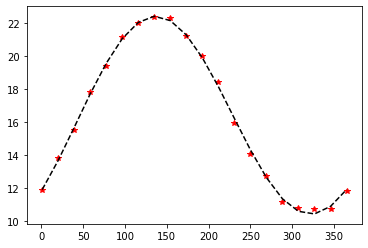

In [15]:
[trig_approx, trigA] = approx.trig_approximation(main_X, main_U, 3, 0.0027*np.pi)
[trig_approx_s, trigB] = approx.trig_approximation(main_T, main_U, 3, np.pi)
plt.plot(main_X, main_U, 'r*', main_X, trig_approx, 'k--')
plt.show()

# Wyznaczanie błędów poszczególnych aproksymacji
Oglądając wykresy nietrudno zauważyć, że jedyne sensowne modele aproksymacji dla powyższych pomiarów to aproksymacja wielomianem 7'ego stopnia oraz trygonometryczna. Stąd to na nich przeprowadzone zostaną następne kroki, jakimi jest określenie ich faktycznej zdatności przy pomocy określania błędów.

### Określenie średnich błędów względnych i bezwzględnych obu metod

In [16]:
print(
	approx.av_rel_error(main_U, seventh_deg_poly),
	approx.av_rel_error(main_U, seventh_deg_poly_s),
	approx.av_rel_error(main_U, trig_approx),
	approx.av_rel_error(main_U, trig_approx_s)
)
print(
	approx.av_abs_error(main_U, seventh_deg_poly),
	approx.av_abs_error(main_U, seventh_deg_poly_s),
	approx.av_abs_error(main_U, trig_approx),
	approx.av_abs_error(main_U, trig_approx_s)
)

0.009502184656836955 0.00950218361569979 0.010460971273952456 0.01141215387246362
0.1407016456764243 0.14070163237600583 0.15119137659862955 0.163683665721366


### Obliczenie RMSE oraz współczynnik determinancji obu metod

In [17]:
print(
	approx.rmse(main_U, seventh_deg_poly),
	approx.rmse(main_U, seventh_deg_poly_s),
	approx.rmse(main_U, trig_approx),
	approx.rmse(main_U, trig_approx_s)
)
print(
	approx.determination_coeff(main_U, seventh_deg_poly),
	approx.determination_coeff(main_U, seventh_deg_poly_s),
	approx.determination_coeff(main_U, trig_approx),
	approx.determination_coeff(main_U, trig_approx_s)
)

0.1573462515834072 0.15734625158341134 0.17056104089843488 0.17738528186241165
0.9986431994641581 0.998643199464158 0.9984057263089332 0.998275598592591


In [18]:
output_to_text = np.array([
		main_X, main_T, main_U
	], 
	dtype=object
	)

standarised = np.array([
	first_deg_poly_s,
	second_deg_poly_s,
	seventh_deg_poly_s,
	trig_approx_s,
	rat_approx_s
],
	dtype=object)

non_standarised = np.array([
	first_deg_poly,
	second_deg_poly,
	seventh_deg_poly,
	trig_approx,
	nat_approx,
	rat_approx
], dtype=object)
np.savetxt("main_for_matlab.csv", output_to_text, delimiter=",")
np.savetxt("standarised.csv", standarised, delimiter=",")
np.savetxt("nonstandarised.csv", non_standarised, delimiter=",")